In [1]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Salesforce

In [2]:
salesforce1 = pd.read_csv('salesforce.raw.stg_salesforce__account.csv')

In [3]:
salesforce1.shape
salesforce1.ACCOUNT_ID.nunique()

(202357, 9)

202357

Let's see if the raw data in Fivetran has more records than what we need

In [4]:
salesforce0 = pd.read_csv('FIVETRAN.SALESFORCE.ACCOUNT.csv')

/var/folders/0g/ppby4y5x49q9vblv2453c8g40000gq/T/ipykernel_77216/3034199866.py:1: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  salesforce0 = pd.read_csv('FIVETRAN.SALESFORCE.ACCOUNT.csv')


In [5]:
salesforce0.shape
salesforce0.ID.nunique()

(209769, 13)

209769

In [6]:
salesforce0.ID.nunique() - salesforce1.ACCOUNT_ID.nunique()

7412

There are 7,412 accounts missing in the staging table. Looking at the staging view code, the filtered rows are those that have the `is_deleted` flag, so we can focus on the staging view and ignore (and remove) the raw data from Fivetran

In [7]:
del salesforce0

In [8]:
salesforce1.INVOICING_CUSTOMER_ID = salesforce1.INVOICING_CUSTOMER_ID.astype('Int64')

Find if there are any CSR IDs that are used in multiple accounts.

In [9]:
salesforce1_csr_id_counts = salesforce1[salesforce1.INVOICING_CUSTOMER_ID.notnull()].groupby('INVOICING_CUSTOMER_ID').ACCOUNT_ID.count()
salesforce1_csr_ids_multiple_accounts = salesforce1_csr_id_counts[salesforce1_csr_id_counts > 1].index.tolist()
salesforce1_csr_ids_multiple_accounts

[2167, 2292, 2546, 3415]

There are four. Let's take a look at them.

In [10]:
salesforce1[salesforce1.INVOICING_CUSTOMER_ID.isin(salesforce1_csr_ids_multiple_accounts)].sort_values('INVOICING_CUSTOMER_ID')

,ACCOUNT_ID,ACCOUNT_NAME,ACCOUNT_TYPE,REGION,INVOICING_CUSTOMER_NAME,INVOICING_CUSTOMER_ID,BILLING_ID,PARENT_ACCOUNT_ID,TOP_LEVEL_PARENT_ACCOUNT_ID
6197,001G000001IJ6FxIAL,Ingram Micro Mobility,Customer,NORTH_AMERICA,INGRAMMICROMOBILITY,2167,INGRAMMICROMOBILITY,001A000000IkvTDIAZ,001A000000QqxjIIAR
76206,001G000000fva0SIAQ,"CEVA Contract Logistics U.S., Inc.",Customer,NORTH_AMERICA,NaN,2167,NaN,0018Y00002y7NLWQA2,0018Y00002tiAp4QAE
6984,0011600001mq1YFAAY,Werner Electric Minnesota,Customer,NORTH_AMERICA,WERNERMN,2292,VANMETERINDUSTRIAL,001A000000Iku09IAB,001A000000Iku09IAB
88903,001A000000Iku09IAB,Van Meter Inc.,Customer,NORTH_AMERICA,VANMETERINC,2292,VANMETERINDUSTRIAL,NaN,001A000000Iku09IAB
94558,0011M00002ZFX0LQAX,Altorfer Industries,Customer,NORTH_AMERICA,ALTORFERINDUSTRIES,2546,ALTORFERINDUSTRIES,001A000000JZHnZIAX,001A000000JZHnZIAX
149190,001A000000JZHnZIAX,Altorfer Inc,Customer,NORTH_AMERICA,ALTORFER,2546,ALTORFER,NaN,001A000000JZHnZIAX
122473,001A000000IkuO6IAJ,Thrifty Supply Company,Customer,NORTH_AMERICA,NaN,3415,THRIFTYSUPPLY,0011M00002RJJUcQAP,0011M00002RJJUcQAP
134772,0011M00002RJJUcQAP,Glacier Supply Group,Customer,NORTH_AMERICA,THRIFTYSUPPLY,3415,THRIFTYSUPPLY,NaN,0011M00002RJJUcQAP


Let's look at the Salesforce account types that have CSR IDs:

In [11]:
salesforce1[salesforce1.INVOICING_CUSTOMER_ID.notnull()].shape
salesforce1[salesforce1.INVOICING_CUSTOMER_ID.notnull()].ACCOUNT_ID.nunique()
salesforce1[salesforce1.INVOICING_CUSTOMER_ID.notnull()].groupby('ACCOUNT_TYPE').ACCOUNT_ID.count()

(2454, 9)

2454

ACCOUNT_TYPE
Customer                          1424
Dead                                35
Decision Elsewhere                   5
Division of Client                 131
Inactive Client                    658
Lost                                42
MQL                                  1
Other                               15
Parent of Client                     6
Partner                              5
Partner Client                       3
Partner Client Using Billtrust      14
Partner Dead                         1
Partner Prospect                     3
Partner RAW                          1
Partner Suspect                      1
Prospect                            51
RAW                                 24
SAL                                 29
SQL                                  5
Name: ACCOUNT_ID, dtype: int64

2454 of the Salesforce accounts have a CSR ID. Quite a few of them are not marked as a Customer (or Division of Client). The majority of them are inactive clients, but there's a long tail of other types.

## CSR

In [23]:
csr_1 = pd.read_csv('CSR_Stack1.csv')
csr_2 = pd.read_csv('CSR_Stack2.csv')

In [24]:
csr_1.shape
csr_2.shape

(3509, 193)

(729, 193)

In [25]:
csr_1.columns.tolist() == csr_2.columns.tolist()

True

In [26]:
csr = pd.concat([csr_1, csr_2])

In [27]:
csr = csr[['CustomerId', 'UserName', 'EmailPrimary', 'CustomerStatus']]

In [28]:
del csr_1, csr_2

In [29]:
csr.shape
csr.CustomerId.nunique()
csr.head()

(4238, 4)

4236

,CustomerId,UserName,EmailPrimary,CustomerStatus
0,-3015,FEDEX,Billtrust_FXF_Contact@corp.ds.fedex.com,99
1,-2706,JIMESTACK2B2C,jime@billtrust.com,99
2,-2704,JIMESTACK2B2B,jime@billtrust.com,99
3,-2702,STAPLESUS,karen.orris@staples.com,99
4,-2666,NORTHOFBOSTON,nroy@eagletribune.com,99


In [30]:
csr['CustomerId'] = csr.CustomerId.astype('Int64')

In [31]:
salesforce1.shape
salesforce1.ACCOUNT_ID.count()
salesforce1.ACCOUNT_ID.nunique()

(202357, 9)

202357

202357

In [32]:
csr.shape
csr.CustomerId.count()
csr.CustomerId.nunique()

csr.CustomerId.count() - csr.CustomerId.nunique()

(4238, 4)

4238

4236

2

Since there are 2 more rows than unique CSR IDs, some IDs are duplicated. Let's find them:

In [33]:
csr_num_ids = csr.groupby('CustomerId').CustomerId.count()
with pd.option_context('display.max_rows', None,):
    csr[csr.CustomerId.isin(csr_num_ids[csr_num_ids > 1].index.tolist())].sort_values('CustomerId')

,CustomerId,UserName,EmailPrimary,CustomerStatus
445,500,BILLTRUST,avigotito@billtrust.com,5
0,500,BILLTRUST3,avigotito@billtrust.com,5
639,698,FACTORSYSTEMS,billing@billtrust.com,5
3,698,FACTORSYSTEMS,btarteam@billtrust.com,5


In [34]:
csr.groupby('CustomerStatus').CustomerId.nunique()

CustomerStatus
1        57
5      2731
99     1286
111     162
Name: CustomerId, dtype: int64

Same, but looking at negative CustomerIDs

In [35]:
csr['CustomerIdAbs'] = csr.CustomerId.abs() 

In [36]:
csr_num_ids = csr.groupby('CustomerIdAbs').CustomerId.count()
csr[csr.CustomerIdAbs.isin(csr_num_ids[csr_num_ids > 1].index.tolist())].CustomerIdAbs.nunique()
with pd.option_context('display.max_rows', None,):
    csr[csr.CustomerIdAbs.isin(csr_num_ids[csr_num_ids > 1].index.tolist())].sort_values('CustomerIdAbs')

37

,CustomerId,UserName,EmailPrimary,CustomerStatus,CustomerIdAbs
445,500,BILLTRUST,avigotito@billtrust.com,5,500
0,500,BILLTRUST3,avigotito@billtrust.com,5,500
1,569,METROCLUB,ttesto@metroclub.org,5,569
34,-569,METROCLUB,ttesto@metroclub.org,99,569
2,688,UNITEDTILE,barb@unitedtile.com,5,688
33,-688,UNITEDTILE,barb@unitedtile.com,99,688
3,698,FACTORSYSTEMS,btarteam@billtrust.com,5,698
639,698,FACTORSYSTEMS,billing@billtrust.com,5,698
4,862,CHIQUITA,mlocke@chiquita.com,5,862
32,-862,CHIQUITA,mlocke@chiquita.com,99,862


Taking into account negative ids, there are 37 duplicated customers. For 33 of them, there is one record with status 5 and another with 99. In the other 4 cases both rows have the same status.

Let's see how many distinct CSR IDs there are, not taking into account duplicates (or the ones with a negative CSR ID)

In [44]:
csr_ids = csr.CustomerIdAbs.dropna().unique().tolist()
len(csr_ids)

4201

And compare them to the number of CSR IDs in Salesforce

In [45]:
salesforce1_csr_ids = salesforce1.INVOICING_CUSTOMER_ID.dropna().unique().tolist()
len(salesforce1_csr_ids)

2450

Do all CSR IDs in Salesforce appear in CSR?

In [46]:
both_salesforce_and_csr_ids = set(salesforce1_csr_ids).intersection(set(csr_ids))
both_salesforce_and_csr = len(both_salesforce_and_csr_ids)
both_salesforce_and_csr

2449

In [47]:
only_salesforce_ids = set(salesforce1_csr_ids).difference(csr_ids)
only_salesforce = len(only_salesforce_ids)
only_salesforce

1

No!

In [48]:
only_salesforce_ids
salesforce1[salesforce1.INVOICING_CUSTOMER_ID == 9829]

{9829}

,ACCOUNT_ID,ACCOUNT_NAME,ACCOUNT_TYPE,REGION,INVOICING_CUSTOMER_NAME,INVOICING_CUSTOMER_ID,BILLING_ID,PARENT_ACCOUNT_ID,TOP_LEVEL_PARENT_ACCOUNT_ID
198368,0018Y00002tkRQqQAM,test,Prospect,UNKNOWN,TEST,9829,NaN,NaN,0018Y00002tkRQqQAM


There's 1 CSR ID in Salesforce that's not present in CSR, but it's a TEST account based on the `INVOICING_CUSTOMER_NAME`

In [49]:
only_csr_ids = set(csr_ids).difference(salesforce1_csr_ids)
only_csr = len(only_csr_ids)
only_csr

1752

There are 1,752 CSR_IDs in the CSR data that don't appear in Salesforce

## Mapping

In [50]:
mapping = pd.read_csv('KS_mapping.csv')

In [51]:
mapping.shape
mapping.CSRID.nunique()
mapping.SalesforceAccountid.nunique()
mapping.head()

(3189, 5)

3189

2078

,CSRID,tenantid,CSRUsername,SalesforceAccountid,BillingPlatformAccountID
0,2408,b05ed81b-919f-40fe-9302-ffc34c2d265d,1SUPPLY,001A000000Iku6UIAR,71693.0
1,3338,009e6319-1601-4d6c-986b-3a2367080b55,3E-CO,001A000000IkuAgIAJ,71729.0
2,4568,f28676da-576a-4dd7-8805-2aa39b553646,5SSL,00116000024UXtZAAW,73225.0
3,355,a856bdb8-e1c7-42c5-bf6e-96c068a93f8a,84LUMBER,001A000000Iku0PIAR,71040.0
4,2308,b044a69e-e0f9-4036-9c18-8f025faca0b8,AAACOOPER,001G000000nv05kIAA,72546.0


In [52]:
both_salesforce_and_csr + only_salesforce + only_csr - mapping.CSRID.nunique()

1013

There are 1013 CSR IDs more in the CSR + Salesforce data than in the mapping from Kaustubh

In [53]:
mapping[['CSRID']] = mapping[['CSRID']].astype('Int64')

In [54]:
mapping.dtypes

CSRID                         Int64
tenantid                     object
CSRUsername                  object
SalesforceAccountid          object
BillingPlatformAccountID    float64
dtype: object

Let's look at all the CSR IDs in Salesforce, CSR, and the Billing mapping, to see how many are common between systems or appear only in one of them

In [56]:
sf_ids = salesforce1.INVOICING_CUSTOMER_ID.dropna().unique().tolist()
csr_ids = csr.CustomerIdAbs.dropna().unique().tolist()
mapping_ids = mapping.CSRID.dropna().unique().tolist()

In [57]:
len(sf_ids)
len(csr_ids)
len(mapping_ids)
len(set(sf_ids + csr_ids + mapping_ids))

2450

4201

3189

4202

In [58]:
only_sf = set(sf_ids) - set(csr_ids) - set(mapping_ids)
only_csr = set(csr_ids) - set(sf_ids) - set(mapping_ids)
only_sf_csr = set(sf_ids) & set(csr_ids) - set(mapping_ids)
only_mapping = set(mapping_ids) - set(csr_ids) - set(sf_ids)
only_sf_mapping = (set(sf_ids) & set(mapping_ids)) - set(csr_ids)
only_csr_mapping = (set(csr_ids) & set(mapping_ids)) - set(sf_ids)
sf_csr_mapping = set(csr_ids) & set(mapping_ids) & set(sf_ids)

In [59]:
len_only_sf = len(only_sf)
len_only_csr = len(only_csr)
len_only_sf_csr = len(only_sf_csr)
len_only_mapping = len(only_mapping)
len_only_sf_mapping = len(only_sf_mapping)
len_only_csr_mapping = len(only_csr_mapping)
len_sf_csr_mapping = len(sf_csr_mapping)

In [60]:
len_only_sf
len_only_csr
len_only_sf_csr
len_only_mapping
len_only_sf_mapping
len_only_csr_mapping
len_sf_csr_mapping

1

695

317

0

0

1057

2132

In [61]:
len_only_sf + \
len_only_csr + \
len_only_sf_csr + \
len_only_mapping + \
len_only_sf_mapping + \
len_only_csr_mapping + \
len_sf_csr_mapping

4202

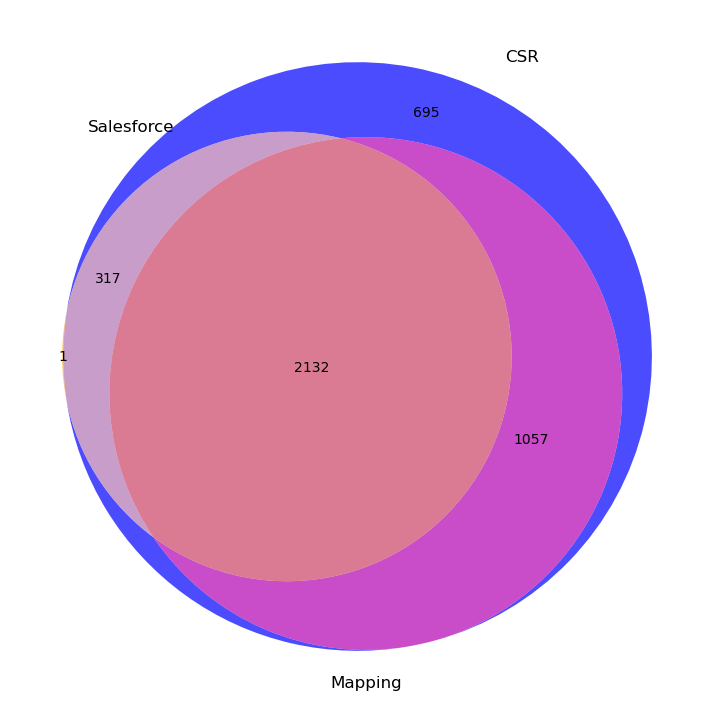

In [62]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from matplotlib import pyplot as plt 
  
# depict venn diagram 
_ = plt.figure(figsize=(12,9))

out = venn3(subsets=(len_only_sf, len_only_csr, len_only_sf_csr, len_only_mapping, len_only_sf_mapping, len_only_csr_mapping, len_sf_csr_mapping),  
      set_labels=('Salesforce', 'CSR', 'Mapping'),  
      set_colors=("orange", "blue", "red"), alpha=0.7) 


x, y = out.subset_labels[1].get_position()

out.subset_labels[1].set_position((x-0.15, y+0.19))

x, y = out.subset_labels[2].get_position()

out.subset_labels[2].set_position((x-0.05, y))

x, y = out.subset_labels[5].get_position()

out.subset_labels[5].set_position((x+0.05, y))
    
plt.show(out)

So CSR, as expected, contains all the CSR IDs available in Salesforce (except for the 1 test account mentioned above) and in the Billing mapping.

## Compare Kaustubh's mapping with the implicit mapping in Salesforce

In [79]:
sf_w_csr_id = salesforce1[salesforce1.INVOICING_CUSTOMER_ID.notnull()].drop_duplicates(subset=['INVOICING_CUSTOMER_ID']).dropna(subset='INVOICING_CUSTOMER_ID')
sf_w_csr_id.shape

(2450, 9)

In [87]:
sf_mapping = pd.merge(salesforce1[['ACCOUNT_ID', 'ACCOUNT_NAME', 'ACCOUNT_TYPE', 'INVOICING_CUSTOMER_ID', 'INVOICING_CUSTOMER_NAME']], 
         mapping[['CSRID', 'CSRUsername', 'SalesforceAccountid']], left_on='INVOICING_CUSTOMER_ID', right_on='CSRID', how='outer')\
    .dropna(subset=['INVOICING_CUSTOMER_ID', 'CSRID'], how='all')

In [88]:
sf_mapping.shape
sf_mapping.head()

(3511, 8)

,ACCOUNT_ID,ACCOUNT_NAME,ACCOUNT_TYPE,INVOICING_CUSTOMER_ID,INVOICING_CUSTOMER_NAME,CSRID,CSRUsername,SalesforceAccountid
199903,0011600001uk9uSAAQ,Raymond Storage Concepts,Customer,2881,RAYMONDSCI,2881,RAYMONDSCI,0011600001uk9uSAAQ
199904,001G0000010CgQLIA0,MasterCard,Customer,5103,MASTERCARD,5103,MASTERCARD,001G0000010CgQLIA0
199905,0011600001nuEZGAA2,"Sonepar Key Accounts, LLC",Customer,2300,SONEPARKEYACCOUNTS,2300,SONEPARKEYACCOUNTS,0011600001nuEZGAA2
199906,001PI000004Pw6ZYAS,TRAINING2,Prospect,5770,TRAINING2,<NA>,NaN,NaN
199907,001A000000JZJarIAH,"Ultradent Products, Inc.",Inactive Client,1805,ULTRADENT,1805,ULTRADENT,001A000000JZJarIAH


In [89]:
sf_mapping[sf_mapping.ACCOUNT_ID.notnull() & sf_mapping.SalesforceAccountid.notnull()].shape
sf_mapping[(sf_mapping.ACCOUNT_ID != sf_mapping.SalesforceAccountid)\
           & sf_mapping.ACCOUNT_ID.notnull()\
           & sf_mapping.SalesforceAccountid.notnull()]

(2044, 8)

,ACCOUNT_ID,ACCOUNT_NAME,ACCOUNT_TYPE,INVOICING_CUSTOMER_ID,INVOICING_CUSTOMER_NAME,CSRID,CSRUsername,SalesforceAccountid
199969,001G000000fva0SIAQ,"CEVA Contract Logistics U.S., Inc.",Customer,2167,NaN,2167,INGRAMMICROMOBILITY,001G000001IJ6FxIAL
199978,0011600001mq1YFAAY,Werner Electric Minnesota,Customer,2292,WERNERMN,2292,VANMETERINC,001A000000Iku09IAB
201072,0011M00002ZFX0LQAX,Altorfer Industries,Customer,2546,ALTORFERINDUSTRIES,2546,ALTORFER,001A000000JZHnZIAX
201402,001A000000IkuO6IAJ,Thrifty Supply Company,Customer,3415,NaN,3415,THRIFTYSUPPLY,0011M00002RJJUcQAP


The mapping from Billing had 3,189 records, each with a distinct CSR ID

When joining Salesforce data and the mapping from Billing by the CSR ID, we get 2,044 records in which both sources have both a CSR ID and a Salesforce ID. In all but 4 of them, the mapping of the CSR ID to the Salesforce ID in the mapping from Billing is the same as what we find in Salesforce. The only 4 for which this does not happen are listed above.

These are the cases for which we need to decide if we use the mapping from Billing or what we find in Salesforce.

## Finance

In [90]:
finance = pd.read_csv('FINANCE.PRESENTATION.FACT_REVENUE.csv')

The financial data is identified by a `CUSTOMER_ID` that looks like the CSR Username

In [94]:
finance.shape
finance.head()

(2990565, 11)

,CUSTOMER_ID,ACCOUNT_NUMBER,AMOUNT,CURRENCY,ITEM_ID,ENTERED_ON,BOOK_ID,REVENUE_TYPE,DATA_ANALYTICS_PRODUCT_FAMILY,IS_RECURRING_REVENUE,IS_NET_REVENUE
0,SPRINGSWINDOWFASHION,45101,-26.03,NaN,Storage4Y,2022-08-31,ASC606ACCRUAL,Transactional-Invoicing,Invoicing,Yes,True
1,VERTIV,45101,5.06,NaN,Storage7Y,2022-08-31,ASC606ACCRUAL,Transactional-Invoicing,Invoicing,Yes,True
2,VERTIV,45101,-5.06,NaN,Storage7Y,2022-08-31,ASC606ACCRUAL,Transactional-Invoicing,Invoicing,Yes,True
3,MSSUPPLY,45101,3.04,NaN,Storage7Y,2022-08-31,ASC606ACCRUAL,Transactional-Invoicing,Invoicing,Yes,True
4,MSSUPPLY,45101,-3.04,NaN,Storage7Y,2022-08-31,ASC606ACCRUAL,Transactional-Invoicing,Invoicing,Yes,True


In [95]:
finance[finance.CUSTOMER_ID != '(blank)'].CUSTOMER_ID.dropna().nunique()
finance_csr_usernames = finance[finance.CUSTOMER_ID != '(blank)'].CUSTOMER_ID.dropna().unique().tolist()

2125

Removing the rows for which the `CUSTOMER_ID` is `(blank)` in the Finance data, we are left with 2,125 distinct CSR Usernames

In [97]:
mapping_csr_usernames = mapping.CSRUsername.dropna().unique().tolist()
len(mapping_csr_usernames)

3189

As we saw earlier with the IDs, there are 3,189 distinct CSR USERNAMES in the mapping from Billing

In [98]:
salesforce_csr_usernames = salesforce1.INVOICING_CUSTOMER_NAME.dropna().unique().tolist()
len(salesforce_csr_usernames)

3053

And there are 3,053 distinct CSR Usernames in Salesforce

Remember that, earlier, we saw that Salesforce had 2,450 distinct CSR IDs. This means that the CSR Usernames appear to be a more complete CSR identifier than the CSR ID within Salesforce 

In [112]:
salesforce1[salesforce1.INVOICING_CUSTOMER_NAME.isnull() & salesforce1.INVOICING_CUSTOMER_ID.notnull()].INVOICING_CUSTOMER_ID.nunique()
salesforce1[salesforce1.INVOICING_CUSTOMER_NAME.notnull() & salesforce1.INVOICING_CUSTOMER_ID.isnull()].INVOICING_CUSTOMER_NAME.nunique()
salesforce1[salesforce1.INVOICING_CUSTOMER_NAME.notnull() & salesforce1.INVOICING_CUSTOMER_ID.notnull()].INVOICING_CUSTOMER_ID.nunique()

2

601

2450

In almost every case in which there is a CSR Username in Salesforce there's a CSR ID (except in two cases), whereas there are 601 cases in which there is a CSR Username but not a CSR ID.

In [101]:
only_finance_csr_usernames = set(finance_csr_usernames) - set(mapping_csr_usernames) - set(salesforce_csr_usernames)
len(only_finance_csr_usernames)

71

There are 71 CSR Usernames in the Finance dataset that can't be found in the mapping from Billing or in Salesforce

In [102]:
only_finance_csr_usernames_ls = list(only_finance_csr_usernames)
only_finance_csr_usernames_ls.sort()

In [103]:
print(*only_finance_csr_usernames_ls, sep=', ')

AMERICANVALVE, ANIXTERPOWERELECTRIC, ANIXTERPOWERUTILITIE, BAYER-AH, BILLGO, BORNQUIST, BRESCOINC, BROCKWHITE, BUILDERSFIRST, CEMSTONEREADYMIX, CENTRALSTATES, CLASSICAUTO, CPSDISTRIBUTORS, CROWNKEYBANK, CSI, DLPARTSCO, DODGEDATA, DORMAKABABESTACCESS, EXIDE, FCXKEYBANK, FISGLOBAL, FORTUNE, FRENCHGERLEMAN, FRIEDMANELECTRIC, FROSTELECTRIC, GENERALPLUMBING, GLOBALCC, GRAYMATTERSYSTEMS, HDSUPPLYFACILITYCR, HDSUPPLYWHITECAP, HOLTTX, ICONTROLLER, INWORKS, ITA, J-MELECTRICSUPPLY, JLESCO, JPMC, KNAACK, KONTOORBRANDS, MARCOLIN, MASCO, MATHESELECTRIC, MERCHANTSMETALS, MIDLTG, MORRISONMVP, NETWES, ONEILELECTRIC, ONESOURCEWATER, ORDER2CASH, OVERKAMPF, PANORAMIC, PATTENCAT, PCISCIENTIFIC, REXELENERGY, ROCKRIVERILWATER, SERVICESUPPLYOV, STANLEYMECHANICAL, STANLEYSUPPLYSERVICE, STANLEYVIDMAR, STENNER, SUNSTATEEQ, TAYLOR-DEMERS, TENETSOLUTIONS, THYSSENKRUPPELEVATOR, TOSHIBAAMS, UESOMAHA, USCOINC, VWR, WEIMER-BEARING, WHITEOAKCF, WILLOWELECTRIC


In [104]:
csr[csr.UserName.isin(only_finance_csr_usernames_ls)]

,CustomerId,UserName,EmailPrimary,CustomerStatus,CustomerIdAbs
2432,2520,HOLTTX,gretchen.stepke@holtcat.com,99,2520
2515,2605,MORRISONMVP,NaN,99,2605


Only 2 of the 71 appears in CSR, which seems weird. Probably, what we see in Finance are not CSR Usernames, but Intacct IDs, which I think they said are almost always the same, but not always. We should ask them

## Clarizen

In [105]:
clarizen = pd.read_csv('CLARIZEN.RAW.PROJECT.csv')

In [106]:
clarizen.columns = ['ID', 'NAME', 'C_SALESFORCEACCOUNTID', 'STATE', 'PHASE', 'TRACKSTATUS', 'PROJECT', 'C_CSRID', 'C_CUSTOMER']

In [107]:
clarizen.C_CSRID = clarizen.C_CSRID.astype('Int64')

In [108]:
clarizen.shape
clarizen.head()

(13759, 9)

,ID,NAME,C_SALESFORCEACCOUNTID,STATE,PHASE,TRACKSTATUS,PROJECT,C_CSRID,C_CUSTOMER
0,/Project/50bvyirhry1f00zy8g4fok6p93,CR sessie 259651,0018Y00002kWPS7QAO,Draft,Analysis,Not Active,50bvyirhry1f00zy8g4fok6p93,<NA>,NaN
1,/Project/ycywx2hskqtfoiuxkjaletr3125,WSM-INDUSTRIES - WSM Industries (820)- eSoluti...,NaN,Active,Evaluation,On Track,ycywx2hskqtfoiuxkjaletr3125,820,WSM-INDUSTRIES
2,/Project/34uk39jafd0f9dzx1sxahq1jr3,CR 1609,001PI0000098oLuYAI,Draft,Analysis,Not Active,34uk39jafd0f9dzx1sxahq1jr3,<NA>,NaN
3,/Project/2jxibvpmxku1ku7xed8z72xjw3,CR-1598,0018Y00002kWPHSQA4,Draft,Analysis,Not Active,2jxibvpmxku1ku7xed8z72xjw3,<NA>,NaN
4,/Project/3p8cf76y16xys6u677542up1h1152,"LENNOX - Lennox International, Inc. (2813) - e...",NaN,Active,Analysis,At Risk,3p8cf76y16xys6u677542up1h1152,2813,LENNOX


In [121]:
clarizen.C_SALESFORCEACCOUNTID.nunique()
clarizen.C_CSRID.nunique()
clarizen.C_CUSTOMER.nunique()

2244

1411

1980

In [138]:
clarizen.C_SALESFORCEACCOUNTID.count()
clarizen.C_CSRID.count()
clarizen.C_CUSTOMER.count()

7754

7838

11154

In Clarizen, it seems like the CSR Username is the one that can be found in the largest number of records, although there are more unique Salesforce IDs

In [120]:
cl_csrid_dist_usern = clarizen.groupby('C_CSRID').C_CUSTOMER.nunique().sort_values(ascending=False)
cl_csrid_dist_usern[cl_csrid_dist_usern > 1].value_counts()

C_CUSTOMER
2    37
3     5
Name: count, dtype: int64

In [121]:
cl_usern_dist_csrid = clarizen.groupby('C_CUSTOMER').C_CSRID.nunique().sort_values(ascending=False)
cl_usern_dist_csrid[cl_usern_dist_csrid > 1].value_counts()

C_CSRID
2    25
Name: count, dtype: int64

As we can see, there are 25 cases in Clarizen in which a given CSR Username is associated with two different CSR IDs. Conversely, in 37 cases a given CSR ID is associated with 2 different CSR Usernames, and in 5 cases it is associated with 3 different CSR Usernames

In [123]:
cl_usern_dist_sfid = clarizen.groupby('C_CUSTOMER').C_SALESFORCEACCOUNTID.nunique()
cl_usern_dist_sfid[cl_usern_dist_sfid > 1].value_counts()

C_SALESFORCEACCOUNTID
2    10
Name: count, dtype: int64

In [124]:
cl_sfid_dist_usern = clarizen.groupby('C_SALESFORCEACCOUNTID').C_CUSTOMER.nunique()
cl_sfid_dist_usern[cl_sfid_dist_usern > 1].value_counts()

C_CUSTOMER
2    13
3     1
Name: count, dtype: int64

Similarly, there are cases in which Salesforce IDs and CSR Usernames are not associated with the same one of the other

In [130]:
set(clarizen.C_SALESFORCEACCOUNTID.str.replace('Account.', '').dropna().unique().tolist()) - set(salesforce1.ACCOUNT_ID.dropna().unique().tolist())

{'00116000025MyrDAAS',
 '0018Y00002kWQkHQAW',
 '001A000000IkugFIAR',
 '001A000000Ikv5cIAB'}

There are 4 Salesforce IDs in Clarizen that don't appear in Salesforce

In [131]:
all_csr_ids = list(only_sf) + \
    list(only_csr) + \
    list(only_sf_csr) + \
    list(only_mapping) + \
    list(only_sf_mapping) + \
    list(only_csr_mapping) + \
    list(sf_csr_mapping)

In [132]:
len(all_csr_ids)

4202

In [133]:
set(clarizen.C_CSRID.dropna().unique().tolist()) - set(all_csr_ids)

set()

All CSR IDs in Clarizen appear in the CSR data

In [134]:
all_csr_usernames = set(finance_csr_usernames + mapping_csr_usernames + salesforce_csr_usernames)
len(all_csr_usernames)

4148

In [135]:
len(set(clarizen.C_CUSTOMER.dropna().unique().tolist()) - all_csr_usernames)

157

There are 157 CSR UserNames in Clarizen that can't be found in Salesforce, the mapping from Billing, or the Finance data

It's hard from this to say how we should connect the Clarizen data to the other sources

## Fastlane

### Products report

In [140]:
fl_products = pd.read_csv('CUSTOMER360.RAW.ACCOUNTPRODUCTS.csv')
fl_products.shape

(59486, 17)

In [143]:
fl_products.columns

Index(['ACCOUNT_NAME', 'PRODUCT_NAME', 'PRODUCT_FAMILY', 'ANNIVERSARY_DATE',
       'BP_PRODUCT_START_DATE', 'BP_PRODUCT_END_DATE', 'RATE_TYPE',
       'SF_ACCOUNT_ID', 'BILLING_CYCLE', 'CSR_USERNAME',
       'INCREASE_CAP_PERCENT', 'INCREASE_NOTICE_PERIOD', 'END_OF_PRICE_FREEZE',
       'CONTRACT_EXECUTION_DATE', 'SUBSCRIPTION_RENEWAL_TYPE',
       'COLLECTIONS_BILLING_MODE', 'LOADED_AT'],
      dtype='object')

The two main identifiers in this report are Salesforce ID and CSR Username

In [145]:
fl_pr_sf_ids = fl_products.SF_ACCOUNT_ID.dropna().unique().tolist()
fl_pr_csr_usernames = fl_products.CSR_USERNAME.dropna().unique().tolist()

In [146]:
len(fl_pr_sf_ids)
len(fl_pr_csr_usernames)

1591

1261

In [147]:
fl_products.SF_ACCOUNT_ID.dropna().count()
fl_products.CSR_USERNAME.dropna().count()

22408

27252

There are more unique Salesforce IDs, but more rows have CSR Username than SF ID

In [148]:
len(set(fl_pr_sf_ids) - set(salesforce1.ACCOUNT_ID.dropna().unique().tolist()))

742

It looks like there are 742 Salesforce IDs in the Fastlane Product report that don't appear in SF, which seems very strange

However, the Salesforce IDs in this data appear to be modified to include extra information that indicates the billing cycle. We'll remove this extra info.

In [149]:
fl_pr_real_sf_ids = fl_products.SF_ACCOUNT_ID.str.replace('-.*', '', regex=True).dropna().unique().tolist()

In [150]:
len(fl_pr_real_sf_ids)

1126

This reduces the number of unique Salesforce IDs from 1591 to 1126

In [151]:
len(set(fl_pr_real_sf_ids) - set(salesforce1.ACCOUNT_ID.dropna().unique().tolist()))

13

After removing the additions to the Salesforce IDs, we find 13 in the Fastlane product report that are not present in Salesforce.

In [152]:
set(fl_pr_real_sf_ids) - set(salesforce1.ACCOUNT_ID.dropna().unique().tolist())

{'0011M00002RIxlrQAD',
 '0011M00002ZrpD5QAJ',
 '0011MOQ002RHILKQAL',
 '0011MOQ002RHfBPQA1',
 '001A000000IktxRIAR',
 '001A000000IkugFIAR',
 '001G000001aICzCIAW',
 '001PLACEHOLDER11111',
 '001PLACEHOLDER11112',
 '001PLACEHOLDER99',
 '001TEST_ACCOUNT',
 '001V000000plchldr2',
 'Carolina Caterpillar'}

In [153]:
fl_products.SF_ACCOUNT_ID.shape
fl_products.SF_ACCOUNT_ID.isnull().sum()

(59486,)

37078

In [154]:
fl_products.CSR_USERNAME.shape
fl_products.CSR_USERNAME.isnull().sum()

(59486,)

32234

In [155]:
fl_products.ACCOUNT_NAME.shape
fl_products.ACCOUNT_NAME.isnull().sum()

(59486,)

32045

In [156]:
fl_products[fl_products.CSR_USERNAME.isnull() & fl_products.SF_ACCOUNT_ID.isnull() & fl_products.ACCOUNT_NAME.isnull()].shape

(32045, 17)

There are a ton of rows in this report that don't have any account ID (?!?)

In [157]:
len(set(fl_pr_csr_usernames) - all_csr_usernames)

3

In [158]:
mylist = list(set(fl_pr_csr_usernames) - all_csr_usernames)
mylist.sort()
print(*mylist, sep = ", ")

NEWCASTLEBUILDING, ROBERTSCONCRETE, TESTACCOUNTBP


There are 3 CSR Usernames in this report that don't appear in the list of CSR Usernames from Salesforce, the Billing mapping, or CSR

### Tier Usage Report

In [159]:
fl_usage = pd.read_csv('CUSTOMER360.RAW.TIERUSAGE.csv')
fl_usage.shape

(7000, 10)

In [160]:
fl_usage.columns

Index(['SERVICE_NAME', 'PRODUCT_FAMILY', 'BILLING_ID', 'USAGE_MONTH',
       'USAGE_YEAR', 'MONTHLY_USAGE', 'PERIOD_TO_DATE_USAGE', 'TIER_ACHIEVED',
       'SUB_MO_NO', 'LOADED_AT'],
      dtype='object')

The only identifier here is `BILLING_ID`, which I understand is the same as Intacct ID, close but not always the same as CSR Username

In [163]:
fl_us_billing_ids = fl_usage.BILLING_ID.dropna().unique().tolist()
len(fl_us_billing_ids)
fl_usage.BILLING_ID.isnull().sum()

765

0

There is always a `BILLING_ID` here, and in the 7000 rows in the file we find 765 distinct `BILLING_ID`s

In [166]:
len(set(fl_us_billing_ids) - all_csr_usernames)

0

All these `BILLING_ID`s appear in the list of CSR Usernames we have from the other sources

In [170]:
len(set(fl_us_billing_ids) - set(salesforce_csr_usernames))
set(fl_us_billing_ids) - set(salesforce_csr_usernames)

8

{'ACUSHNETCA',
 'CROWNKEYBANK',
 'ERIEMATERIALS',
 'FCXKEYBANK',
 'MONDELEZWAREHOUSE',
 'RHFOSTERCC',
 'TMAG-CA',
 'VANMETERINDUSTRIAL'}

In [171]:
len(set(fl_us_billing_ids) - set(mapping_csr_usernames))
set(fl_us_billing_ids) - set(mapping_csr_usernames)

5

{'CROWNKEYBANK', 'FCXKEYBANK', 'OAKH', 'STAPLES', 'WATERLOGIC'}

Yet not all of them are in Salesforce or the mapping from Billing